# Lanes Recognition

## Resources:

 * [Udacity: Open Source Self-Driving Car](https://github.com/udacity/self-driving-car)

## Import Packages

In [1]:
import numpy as np
import os
import pickle
import glob
import math

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
import cv2

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from moviepy.editor import *
from moviepy.video.tools.cuts import find_video_period
from moviepy.audio.tools.cuts import find_audio_period

## Read Images

In [7]:
img = mpimg.imread("../data/raw/Lane01.jpg")

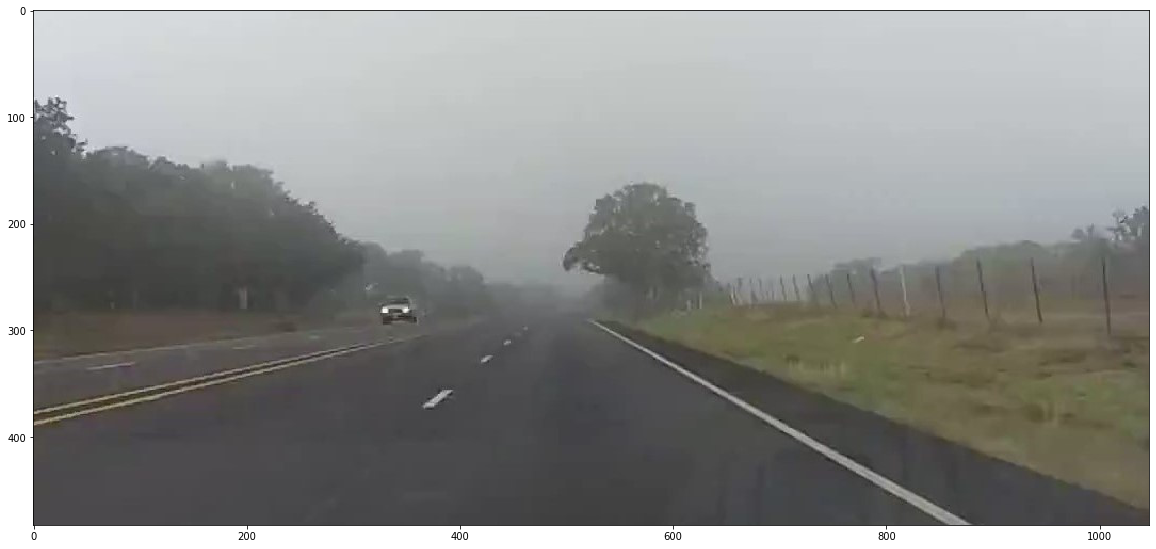

In [8]:
plt.imshow(img)

In [9]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

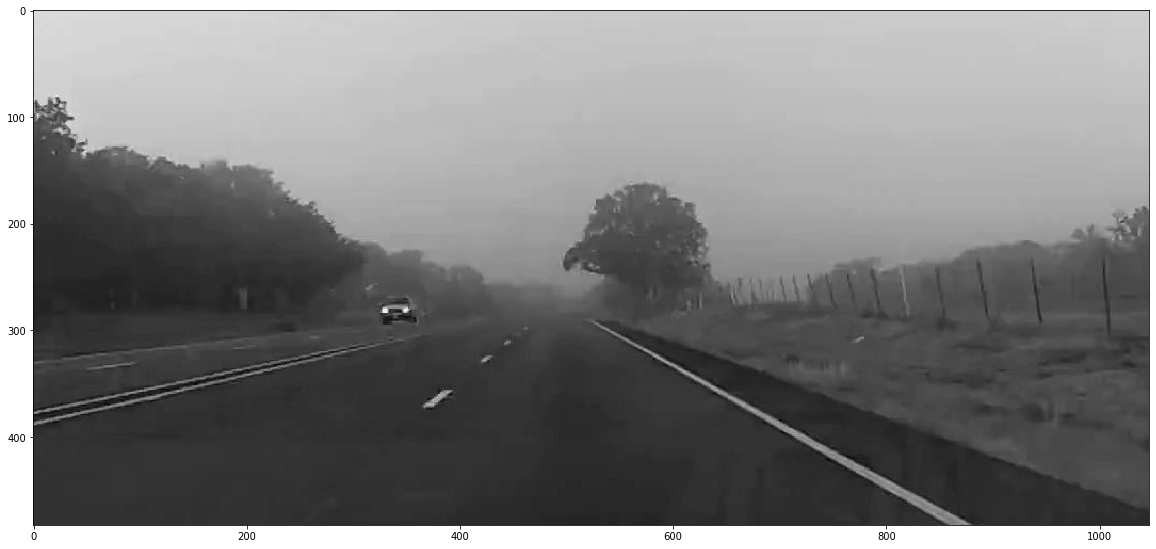

In [10]:
plt.imshow(img_gray, cmap='gray')

In [11]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

Read and save test images to array:

In [12]:
test_images = [read_image(i) for i in glob.glob('../data/raw/*.jpg')]

In [13]:
len(test_images)

2

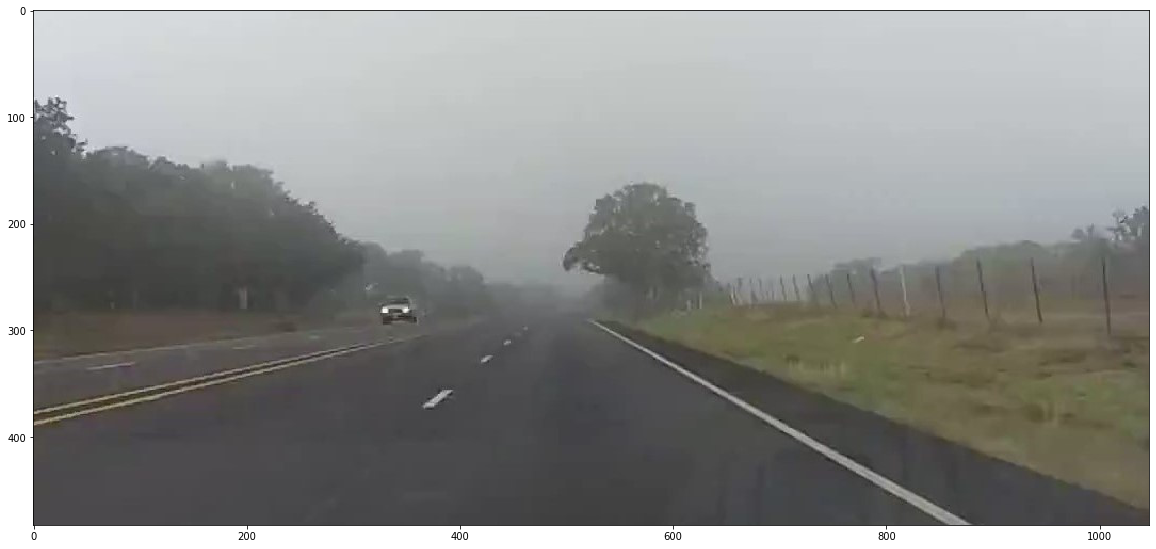

In [14]:
plt.imshow(test_images[0])

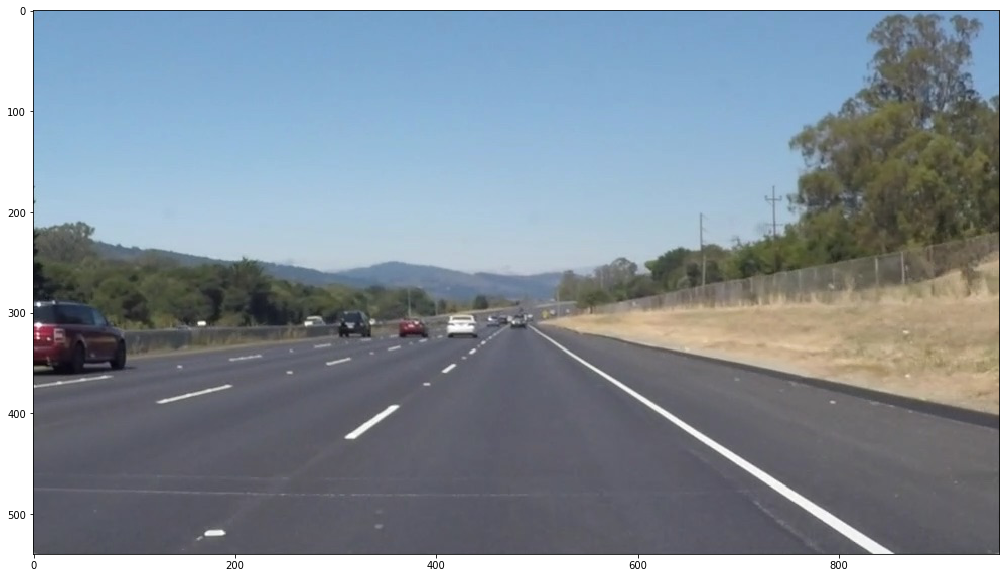

In [15]:
plt.imshow(test_images[1])

## Define helper functions

 * **Canny edge detector** - operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986 ([link](https://en.wikipedia.org/wiki/Canny_edge_detector)
 * **Gaussian blur** - function convolves the source image with the specified Gaussian kernel.
 * **Image mask** - function fills the area bounded by one or more polygons.
 * **Hough line transform** - automated analysis of images todetect detect simple shapes, such as straight lines, circles or ellipses. It was initially invented for machine analysis of **bubble chamber** photographs (Hough, 1959).

In [16]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [17]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [18]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [19]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [20]:
def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Draw Lane Lines

Steps:

 * Read in and grayscale the image
 * Define a kernel size and apply Gaussian smoothing
 * Define our parameters for Canny and apply to get edges image
 * Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
 * Define Hough transform parameters and run Hough transform on masked edge-detected image
 * Draw line segments
 * Draw lines extrapolated from line segments
 * Combine line image with original image to see how accurate the line annotations are.



In [21]:
def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 1)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 100, 300)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

## Test on Images

Slope & intercept:  [[0.6227758007117438, 7.1494661921708484], [0.6519607843137255, -4.735294117647072], [0.6515837104072398, -5.022624434389172]]
Slope:  0.6421067651442364 Intercept:  -0.869484119955132
Slope & intercept:  [[-0.6753246753246753, 633.3506493506493], [-0.7521367521367521, 665.9572649572649], [-0.6733333333333333, 631.7333333333333], [-0.776595744680851, 672.7340425531914], [-0.6771653543307087, 636.275590551181]]
Slope:  -0.7109111719612642 Intercept:  648.0101761491239
Coef:  0.6421067651442364 Intercept:  -0.869484119955132 intersection_x:  479.57949593574614
Point one:  (479, 307) Point two:  (960, 615)
Coef:  -0.7109111719612642 Intercept:  648.0101761491239 intersection_x:  479.57949593574614
Point one:  (479, 307) Point two:  (0, 648)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

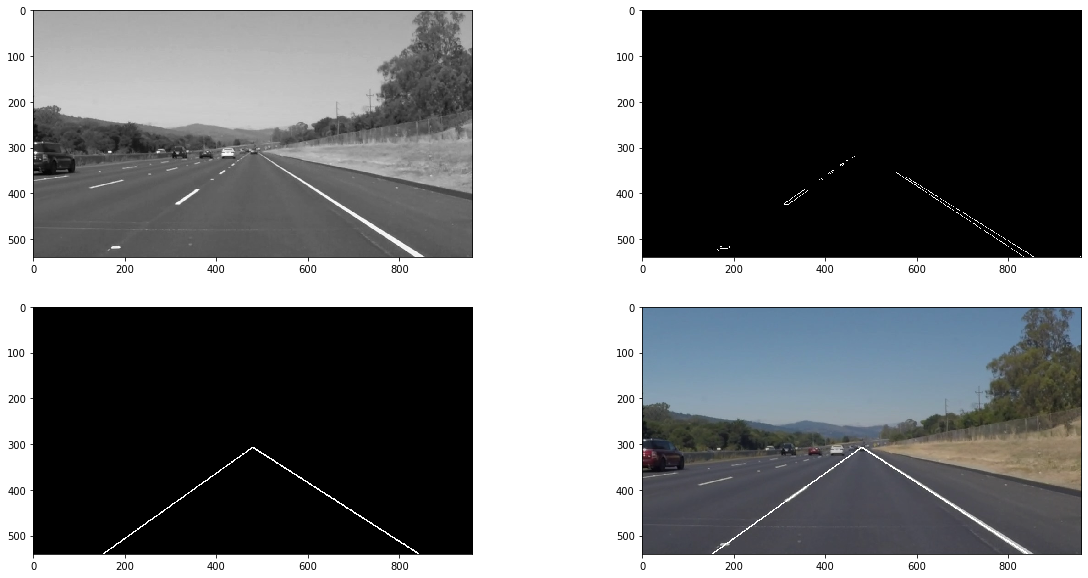

In [22]:
draw_lane_lines(test_images[1])

negative_slope_points still empty
Slope & intercept:  [[0.531578947368421, 13.678947368421063], [0.5774647887323944, -12.056338028169023], [0.5747126436781609, -11.103448275862036], [0.5909090909090909, -22.181818181818187], [0.589041095890411, -21.342465753424676]]
Slope:  0.5727413133156957 Intercept:  -10.601024574170571
Slope & intercept:  []
Slope:  nan Intercept:  nan
Coef:  0.5727413133156957 Intercept:  -10.601024574170571 intersection_x:  nan


ValueError: cannot convert float NaN to integer

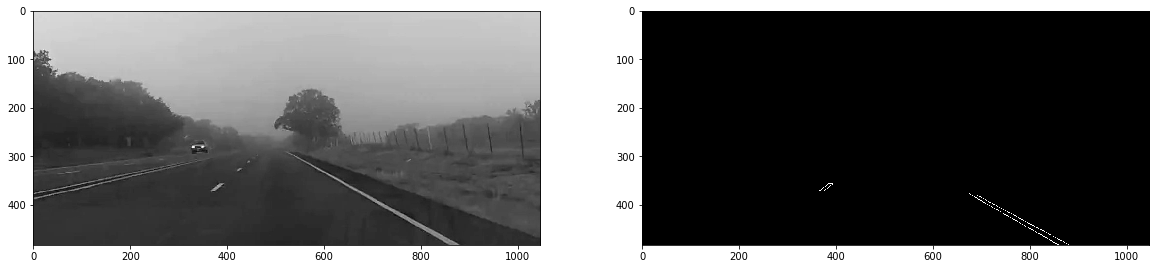

In [23]:
draw_lane_lines(test_images[0])